<a href="https://colab.research.google.com/github/JunJul/NSDC-Project-Heart-Disease-Classification/blob/Master/Indicator_of_Heart_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction**:

  The project is called the heart disease classification. In this project, as a project lead, I led three people to develop classification models to predict if a person has heart disease based on some simple indicators of heart disease such as BMI, Age, different walking speed, and so on in this dataset from a *CDC* heart disease survey in 2022. **Furthermore, I took respnsbility of EDA, pipeline, Models, and some Data Preprocessing works in the indicators of Heart Disease project**.

  The purpose of this project was to help people understand how to avoid heart disease based on some simple indicators. Also, people can examine what probability they are getting heart disease through a machine learning model, so people can have a good life-style to maintain health.
  
  We developed **XGBClassifier, LogisticRegression, DecisionTreeClassifier, and RandomForestClassifier** by sciKit-learn. According to the F1-score and validation score, we concluded that the RandomForestClassifier and the DecisionTreeClassifier outperformed than others. The RandomForestClassifier achieves 97% in F1-score and 96% in validation score. The DecisionTreeClassifier almost has the same result as the RandomForestClassifier.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## **Functions**

Author: Junze He

In [ ]:
# split the features into numerical and categorical features
def split_types(data):
  numerical_features = data.select_dtypes(["int64", "float64"])
  categorical_features = data.select_dtypes(["object", "category"])

  return numerical_features, categorical_features

# Encoding Functions
  # encode the categorical features into ordinal numbers
def ordinal_catfeatures_encoder(data):
  encoder = OrdinalEncoder()
  encoded_data = encoder.fit_transform(data)
  encoded_dataframe =  pd.DataFrame(encoded_data)
  encoded_dataframe.columns = data.columns

  return encoded_dataframe

  # one-hot encoding
def onehot_eoncoder(data):
  encoder = OneHotEncoder()
  encoded_data = encoder.fit_transform(data)
  encoded_dataframe = pd.DataFrame(encoded_data.toarray())

  return encoded_dataframe

  # Frequency encoding
def frequency_encoder(data, is_normalize = True):
  length = data.shape[1]
  columns = data.columns
  new_data = data.copy()

  for i in range(length):
    frequency = new_data[columns[i]].value_counts(normalize=True)
    new_data[columns[i]] = new_data[columns[i]].map(frequency)

  return new_data;

# statsmodels for logistic Regression
def statsLogModel(x, y):
  x = sm.add_constant(x)
  statsLogitModel = sm.Logit(y, x).fit()

  return statsLogitModel

# plot the confusion matrix
def confusionMatrixPlot(cm):
    # cm = model.pred_table(threshold=0.5)
    cm_dis = ConfusionMatrixDisplay(cm, display_labels=['No Heart Disease',
                                                        "Heart Disease Detected"])
    cm_dis.plot(cmap=plt.cm.Blues)

# scale data
def scale(x):
  scaler = StandardScaler()
  scaler.fit(x)
  scaled_x = scaler.transform(x)
  return scaled_x

Author: Giovanni Cinque

In [ ]:
# oversampling
def oversampling(x, y):
  ros = RandomOverSampler()
  x, y = ros.fit_resample(x, y)
  return x, y

# undersampling
def undersampling(x,y):
  rus = RandomUnderSampler()
  x, y = rus.fit_resample(x,y)
  return x, y

## **EDA**

In [ ]:
import os
from google.colab import files
import shutil

new_folder = "Data"

if os.path.isdir(new_folder):
  shutil.rmtree(new_folder)

os.mkdir(new_folder)

# Upload Files
uploaded = files.upload()
for filename in uploaded.keys():
  dst_path = os.path.join(new_folder, filename)
  print(f'move {filename} to {dst_path}')
  shutil.move(filename, dst_path)

Saving heart_2020_cleaned.csv to heart_2020_cleaned.csv
move heart_2020_cleaned.csv to Data/heart_2020_cleaned.csv


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Author: Junze He

In [ ]:
# data = pd.read_csv("/content/heart_2020_cleaned.csv")
data = pd.read_csv("/content/Data/heart_2020_cleaned.csv")

In [ ]:
data.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


**The predicted variable is HeartDisease which includes 292422 No as without heart disease and 27373 Yes as having heart disease**

In [ ]:
data.HeartDisease.value_counts()

No     292422
Yes     27373
Name: HeartDisease, dtype: int64

**Most the variables in the dataset are object type and only four variavles are numerical type.**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

**The dataset has 319795 observations.**

In [ ]:
data.shape

(319795, 18)

In [ ]:
data.columns.tolist()

['HeartDisease',
 'BMI',
 'Smoking',
 'AlcoholDrinking',
 'Stroke',
 'PhysicalHealth',
 'MentalHealth',
 'DiffWalking',
 'Sex',
 'AgeCategory',
 'Race',
 'Diabetic',
 'PhysicalActivity',
 'GenHealth',
 'SleepTime',
 'Asthma',
 'KidneyDisease',
 'SkinCancer']

**These are the number of unique values in each variable.**

In [ ]:
data.nunique()

HeartDisease           2
BMI                 3604
Smoking                2
AlcoholDrinking        2
Stroke                 2
PhysicalHealth        31
MentalHealth          31
DiffWalking            2
Sex                    2
AgeCategory           13
Race                   6
Diabetic               4
PhysicalActivity       2
GenHealth              5
SleepTime             24
Asthma                 2
KidneyDisease          2
SkinCancer             2
dtype: int64

**The dataset is clean, so we don't have to clean data**

In [ ]:
data.isnull().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

In [ ]:
data = data.dropna()

In [ ]:
# split response and predicted variables

response_feature = data.HeartDisease
predicted_features = data.drop("HeartDisease", axis=1)

In [ ]:
# split the nuermical and categorical variables from the predicted variables

numerical_data, categorical_data = split_types(predicted_features)

**Since this is a binary classification, so we need to map Yes and No values in the HeartDisease variable to 1 and 0 respectively**

In [ ]:
# map Yes and No values to 1 and 0 respectively

response_feature = response_feature.map({"Yes": 1, "No": 0})
response_feature.head()

0    0
1    0
2    0
3    0
4    0
Name: HeartDisease, dtype: int64

**The martix scatter plot shows the relationship between numerical variables in the predicted variables.**

**The MentalHealth, PhysicalHealth, and sleepTime have the same scale values ranging from 0 to 30, but rhe BMI does not have the same scale.**

**None of them has a significant correaltion, so the muticolleanrity issue does not happen at here**

**Furthermore, none of the numerical variables have a direct correlation with the HeartDisease variable from the last row of the scatter plot, so we have to look into descriptive statstistic to decide which variable is significant to the HeartDisease.**

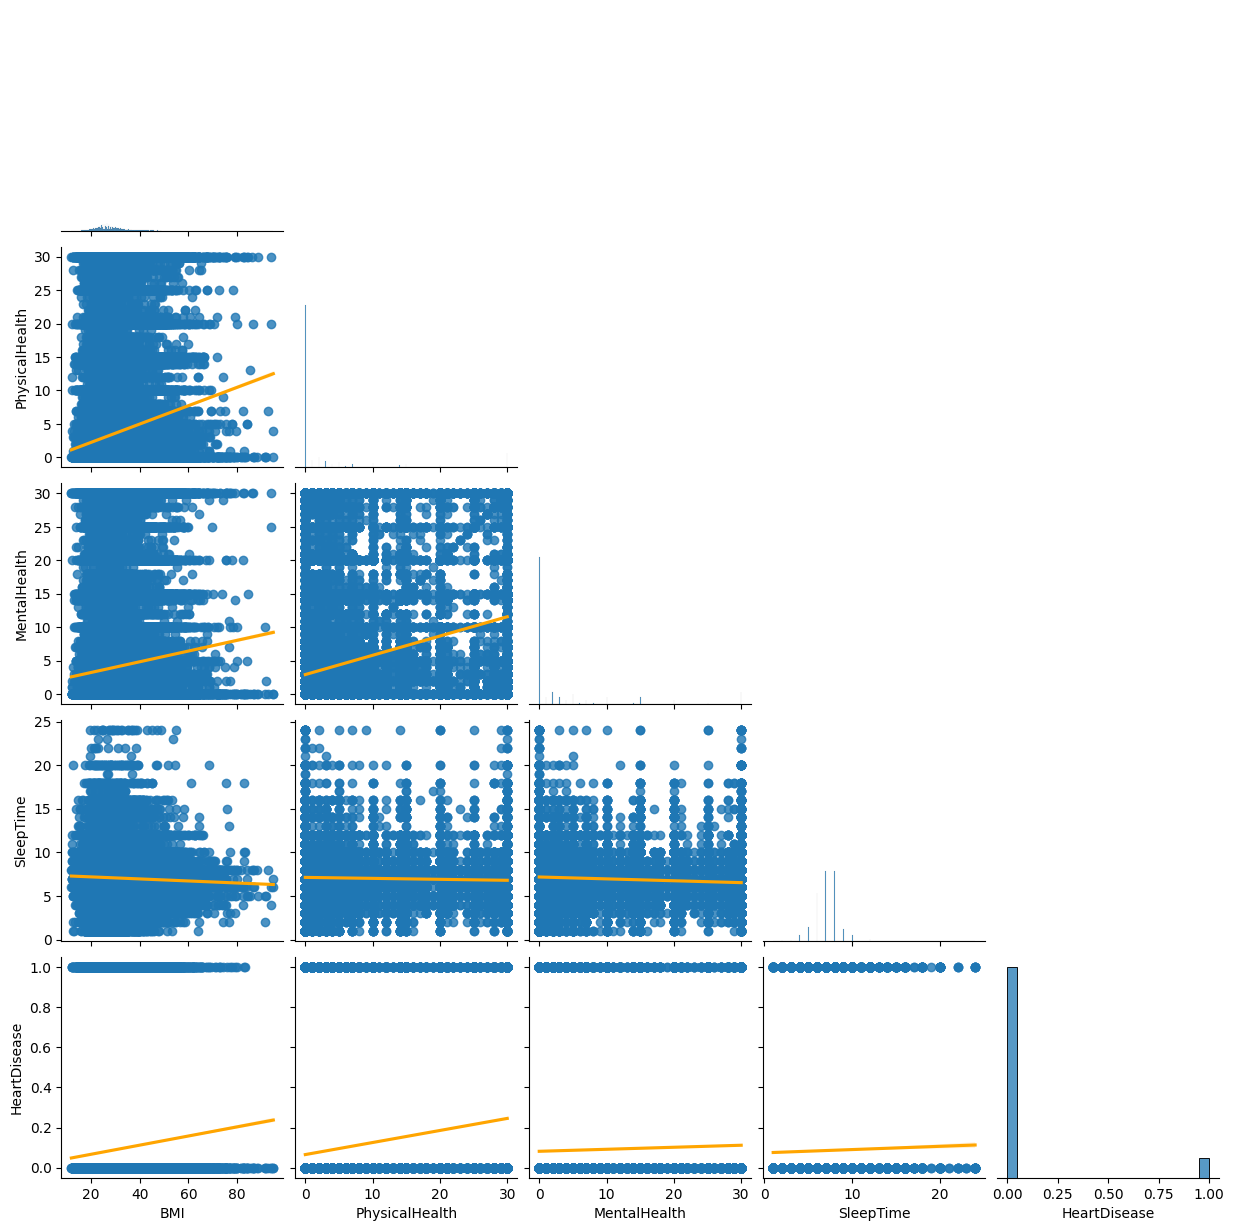

In [ ]:
sns.pairplot(pd.concat([numerical_data, response_feature], axis=1), kind='reg',
             corner=True, plot_kws={'line_kws':{'color':'orange'}})

**The count plot shows the number of observation between Yes and No is different. The No outcome is extremely greater than yes, so the outcomes in reponse variable is imbalance**

<Axes: xlabel='HeartDisease', ylabel='count'>

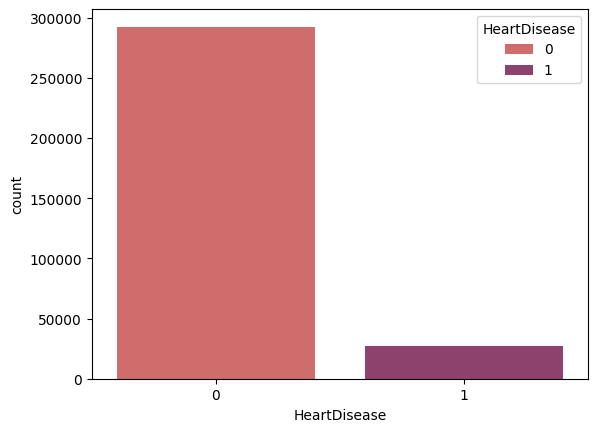

In [ ]:
sns.countplot(x = response_feature,
              hue = response_feature, palette ="flare")

**The matrxiCountPlot function is to create a list of count plot in a matrix form that shows the number of uniqe observation in each categorical variable**

In [ ]:
# The function takes a dataframe arugument to generate a matrix count plot
def maxtrixCountPlot(input_data):
    rows = 4
    cols = 3
    row_count = col_count = 0
    fig, axe = plt.subplots(rows, cols, figsize=(20,15))

    for i in input_data.columns:
        sns.countplot(x = input_data[i],
                      ax=axe[row_count, col_count],
                      hue = input_data[i],
                      palette="flare")
        col_count += 1

        if col_count >= cols:
            col_count = 0
            row_count += 1

    fig.delaxes(axe[3, 1])
    fig.delaxes(axe[3, 2])

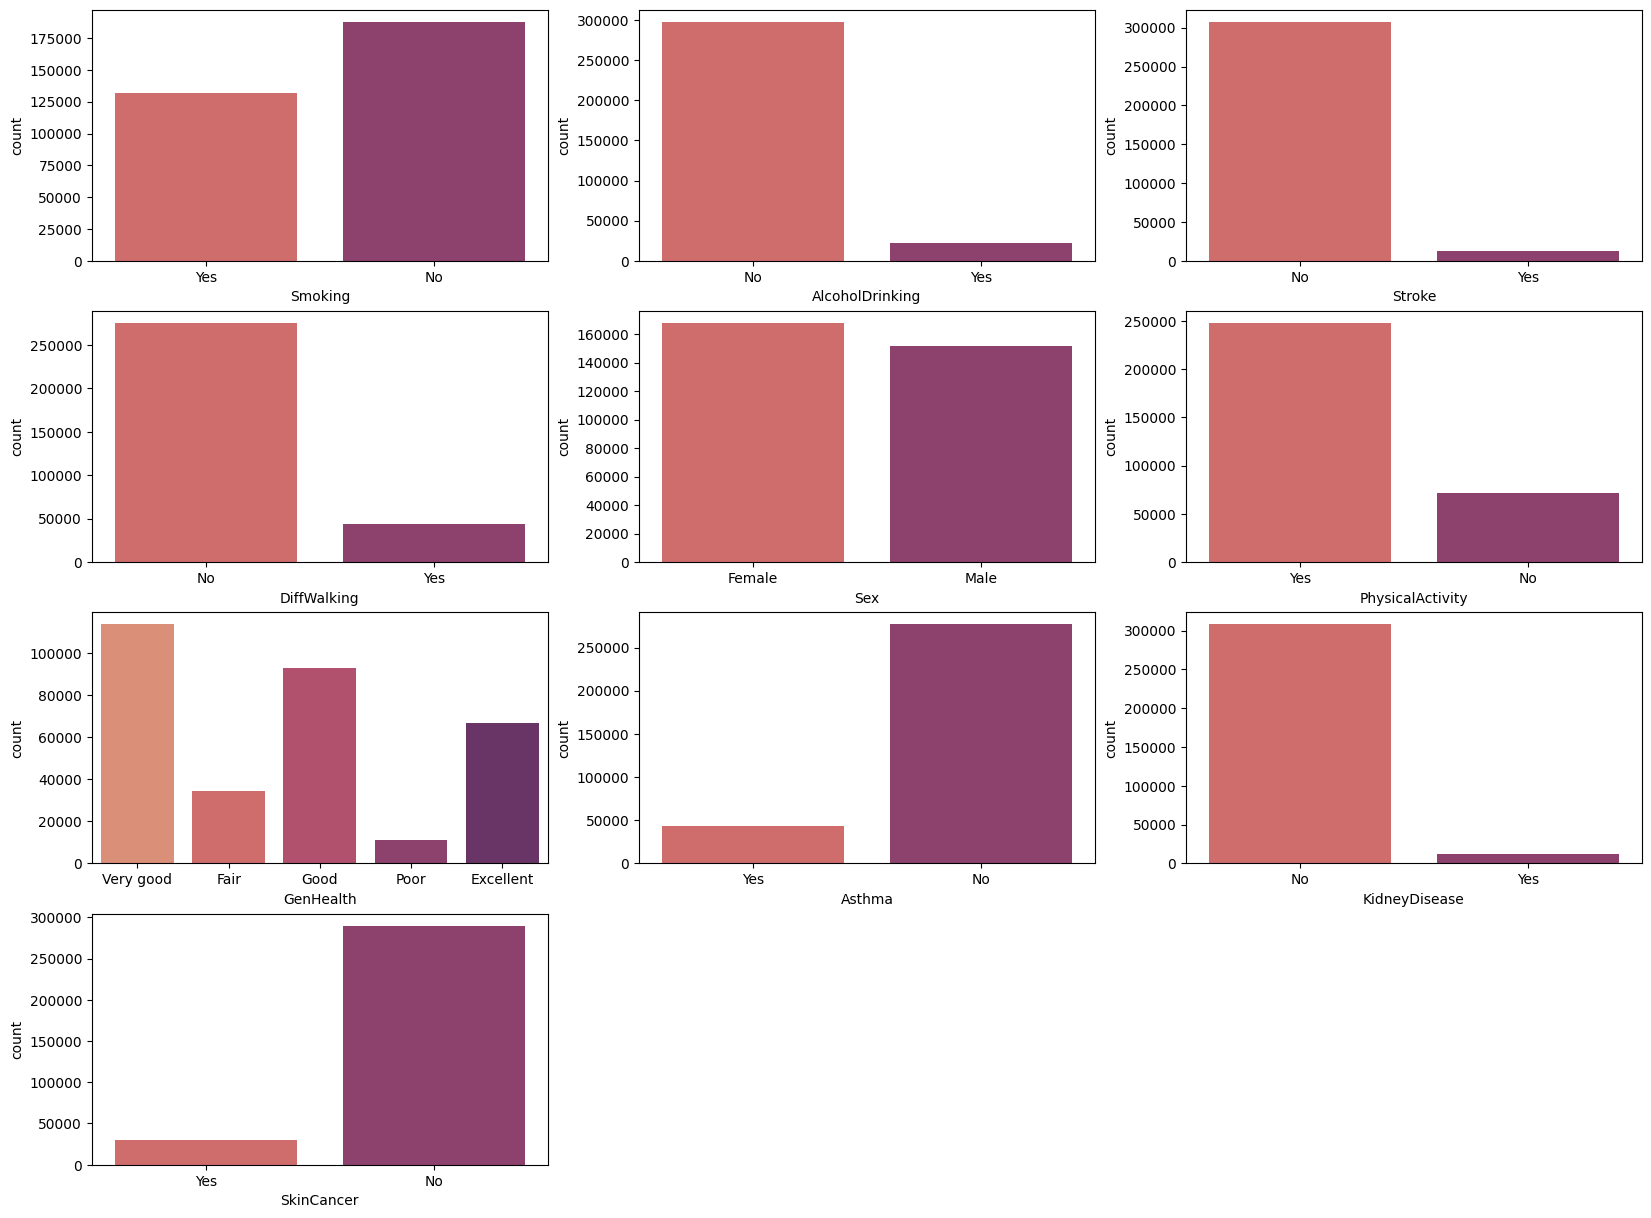

In [ ]:
# sns.countplot(data = categorical_data, x= "Smoking", palette="flare")
maxtrixCountPlot(categorical_data.drop(["Race", "Diabetic", "AgeCategory"], axis=1))

**This is the countplot of Diabetic variable. From the variable, we know that there are two special cases which are No, borderline diabetes and Yes, during pregnancy in the Diabetic variable.**

**The No, borderline diabetes means they have a high blood surgar level than normal but not enough to be identified as diabetes**

**The Yes, during preganacy means a female is diabetic when she is pregnant.**

<Axes: xlabel='count', ylabel='Diabetic'>

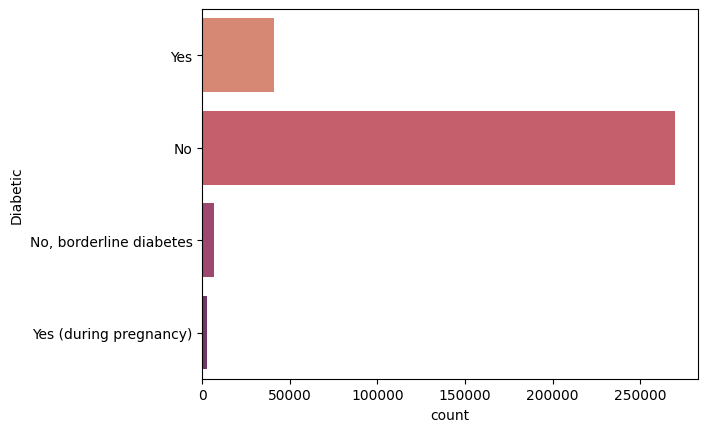

In [ ]:
 sns.countplot(data = categorical_data,
               y = "Diabetic",
               hue = "Diabetic",
               palette="flare")

<Axes: xlabel='count', ylabel='AgeCategory'>

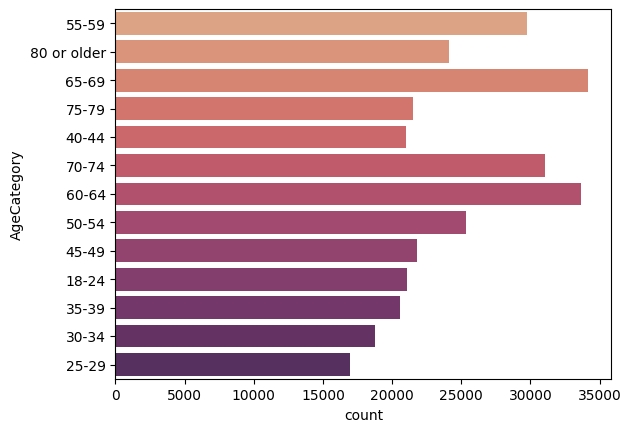

In [ ]:
sns.countplot(data = categorical_data,
               y = "AgeCategory",
               hue = "AgeCategory",
               palette="flare")

**In this dataset, the CDC has more white people as observations**

<Axes: xlabel='count', ylabel='Race'>

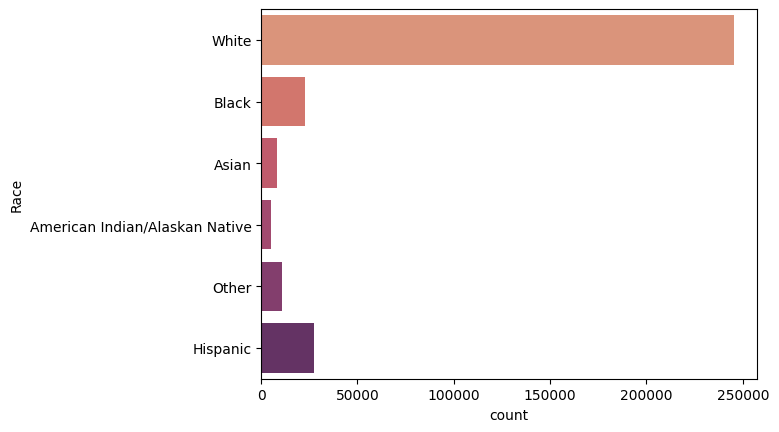

In [ ]:
 sns.countplot(data = categorical_data,
               y = "Race",
               hue = "Race",
               palette="flare")

#### Multicollinearity

**Checking multicollinearity to avoid a model ovefits data**

**This heatmap only consists of numerical varibable, and exactly matches what I mentioned above said they do not have a direct correlation.**

<Axes: >

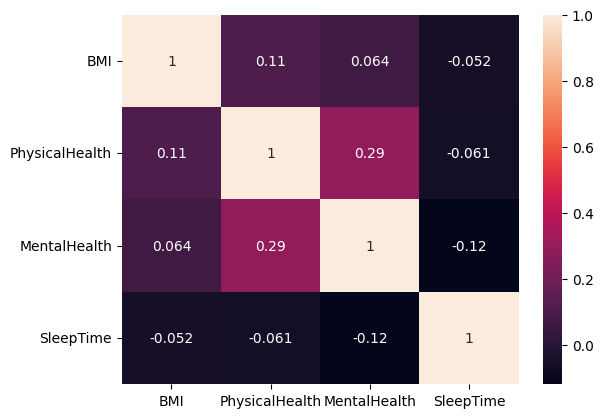

In [ ]:
# calculate correlation between numerical variables
numerical_corrleation = numerical_data.corr()
sns.heatmap(numerical_corrleation, annot=True)

**Encoded categorical variables by ordinal encoding and check multicollinearity among each categorical variable. None of them has a significant correlation, so multicollinearity does not exist in the categorical variables.**

In [ ]:
ordianlEncoded_categories = ordinal_catfeatures_encoder(categorical_data)

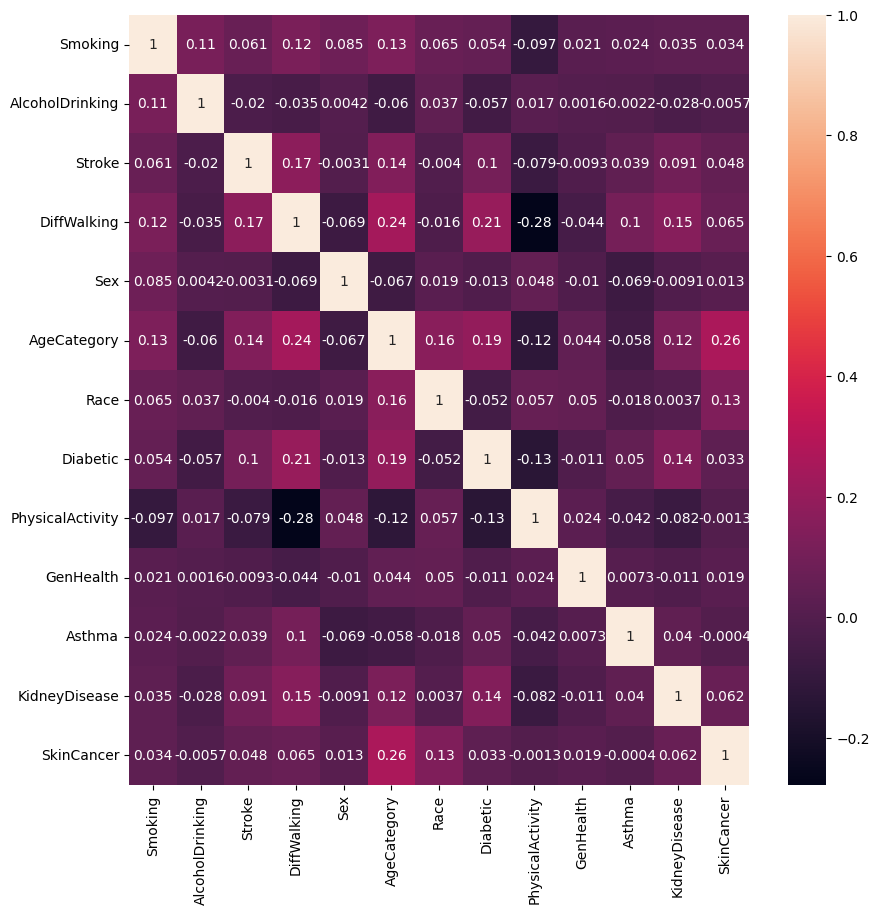

In [ ]:
correlation_cate = ordianlEncoded_categories.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_cate, annot=True)
plt.show()

**Concat numerical and encoded categorical variable and find correlation among them. There is no multicollinearity issue among all the variables in this dataset.**

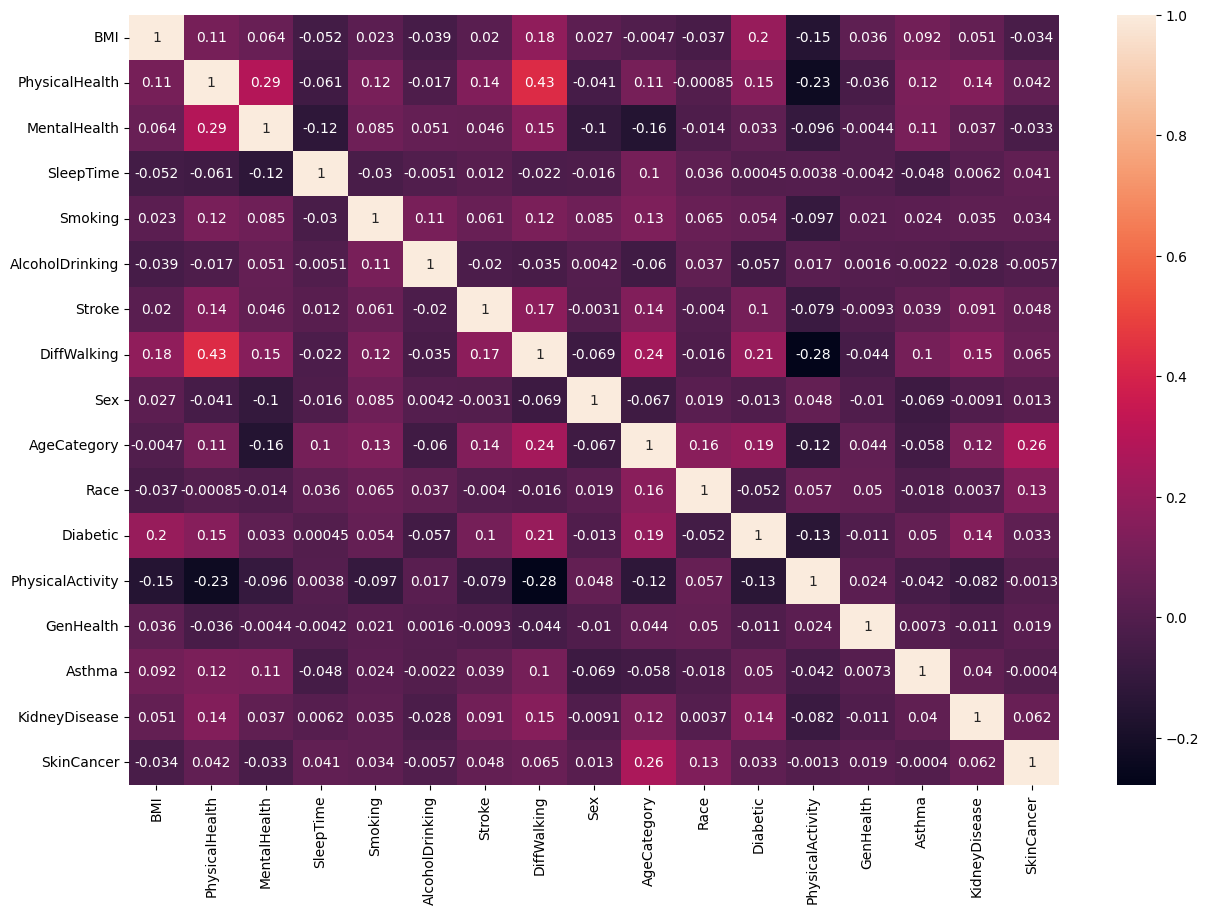

In [ ]:
correlation_numCate = pd.concat([numerical_data, ordianlEncoded_categories], axis = 1).corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_numCate, annot=True)
plt.show()

## StatsModels

**The purpose of develop statsmodels is to uitilize descriptive statistics like checking signifincance of the overall model and predictors.**

**Also, investigate how different encoding technique produce different statistics results.**

### StatsModel1

In [ ]:
statsLogitModel1 = statsLogModel(ordianlEncoded_categories, response_feature)

Optimization terminated successfully.
         Current function value: 0.235142
         Iterations 8


**The statsmodel1 is developed only by categorical variables encoded by ordinal numbers. The p-value is 0 which demonstrates that the model with the predicted variables is significant.**

**All the predicted variables are significant based on their p-values, but AlcoholDrinking has a negative coefficient, so this result is unexpected.**

In [ ]:
statsLogitModel1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           HeartDisease   No. Observations:               319795
Model:                          Logit   Df Residuals:                   319781
Method:                           MLE   Df Model:                           13
Date:                Fri, 29 Mar 2024   Pseudo R-squ.:                  0.1953
Time:                        04:51:15   Log-Likelihood:                -75197.
converged:                       True   LL-Null:                       -93453.
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -5.5114      0.041   -133.054      0.000      -5.593      -5.430
Smoking              0.4654      0.014     33.171      0.000       0.438       0.493
AlcoholDrinking     -0.2681      0.033     -8.101      0.000      -0.333      -0.203
Stroke               1.1961      0.022     53.637      0.000       1.152       1.240
DiffWalking          0.6589      0.016     40.253      0.000       0.627       0.691
Sex                  0.7195      0.014     50.486      0.000       0.692       0.747
AgeCategory          0.2600      0.003     92.863      0.000       0.255       0.266
Race                 0.0371      0.006      5.838      0.000       0.025       0.050
Diabetic             0.3312      0.008     42.566      0.000       0.316       0.346
PhysicalActivity    -0.1854      0.016    -11.934      0.000      -0.216      -0.155
GenHealth           -0.0318      0.005     -6.341      0.000      -0.042      -0.022
Asthma               0.4260      0.019     22.600      0.000       0.389       0.463
KidneyDisease        0.7644      0.024     31.693      0.000       0.717       0.812
SkinCancer           0.1277      0.019      6.646      0.000       0.090       0.165
====================================================================================
"""

**The histogram plot shows that the probability of event No being predicted is way greater than event Yes in statsmodel1.**

(array([2.31921e+05, 4.97810e+04, 1.92640e+04, 8.31600e+03, 4.94300e+03,
        2.74400e+03, 1.51100e+03, 8.09000e+02, 4.07000e+02, 9.90000e+01]),
 array([0.00225504, 0.09584515, 0.18943527, 0.28302538, 0.3766155 ,
        0.47020562, 0.56379573, 0.65738585, 0.75097596, 0.84456608,
        0.93815619]),
 <BarContainer object of 10 artists>)

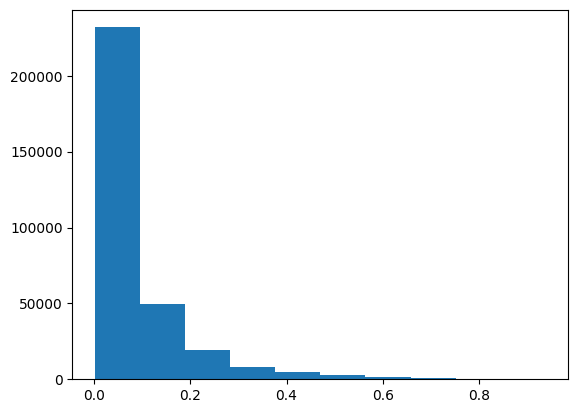

In [ ]:
proba = 1 / (1 + np.exp(- statsLogitModel1.fittedvalues ))
plt.hist(proba)

**The confusion matrix shows there is a high false positive and false negative, so the statsmodel1 does not perform well due to the imbalance outcomes in the reposonse variable.**

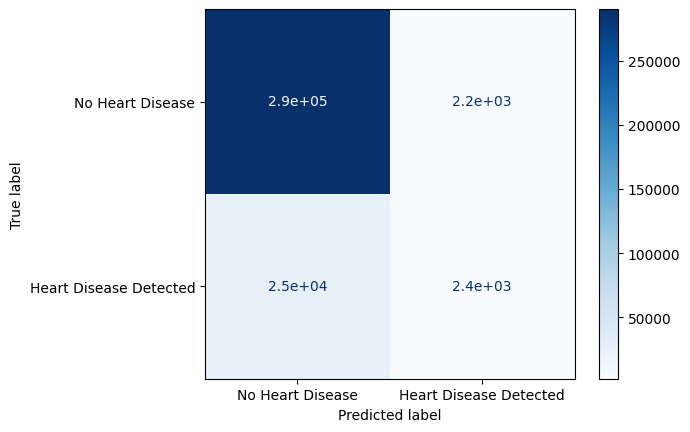

In [ ]:
cm1 = statsLogitModel1.pred_table(threshold=0.5)
confusionMatrixPlot(cm1)

### StatsModel2

**Encoded categorical data by one hot encoding technique**

In [ ]:
onehotencoded_categories = onehot_eoncoder(categorical_data)

**The results from statsmodel2 seems not well because all predicted variables are not significant due to p-value is 1, so it may indicate there is a server multicollinearity problem.**

In [ ]:
statsLogitModel2 = statsLogModel(onehotencoded_categories, response_feature)
statsLogitModel2.summary()

Optimization terminated successfully.
         Current function value: 0.227163
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           HeartDisease   No. Observations:               319795
Model:                          Logit   Df Residuals:                   319761
Method:                           MLE   Df Model:                           33
Date:                Fri, 29 Mar 2024   Pseudo R-squ.:                  0.2226
Time:                        04:51:22   Log-Likelihood:                -72646.
converged:                       True   LL-Null:                       -93453.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3314   9.13e+04  -3.63e-06      1.000   -1.79e+05    1.79e+05
0             -0.3430   4.53e+05  -7.58e-07      1.000   -8.87e+05    8.87e+05
1              0.0115   4.54e+05   2.54e-08      1.000    -8.9e+05     8.9e+05
2             -0.0431   8.52e+04  -5.06e-07      1.000   -1.67e+05    1.67e+05
3             -0.2883   9.24e+04  -3.12e-06      1.000   -1.81e+05    1.81e+05
4             -0.6878   1.95e+05  -3.54e-06      1.000   -3.81e+05    3.81e+05
5              0.3563   1.91e+05   1.87e-06      1.000   -3.74e+05    3.74e+05
6             -0.2930   3.87e+05  -7.58e-07      1.000   -7.58e+05    7.58e+05
7             -0.0384   3.88e+05   -9.9e-08      1.000   -7.61e+05    7.61e+05
8             -0.5162   3.11e+05  -1.66e-06      1.000    -6.1e+05     6.1e+05
9              0.1848   3.11e+05   5.95e-07      1.000   -6.09e+05    6.09e+05
10            -1.6306      5e+05  -3.26e-06      1.000    -9.8e+05     9.8e+05
11            -1.4816   5.04e+05  -2.94e-06      1.000   -9.88e+05    9.88e+05
12            -1.1142      5e+05  -2.23e-06      1.000    -9.8e+05     9.8e+05
13            -1.0032   5.03e+05  -1.99e-06      1.000   -9.86e+05    9.86e+05
14            -0.6029   5.01e+05   -1.2e-06      1.000   -9.83e+05    9.83e+05
15            -0.2829   5.02e+05  -5.63e-07      1.000   -9.84e+05    9.84e+05
16             0.1204   5.01e+05    2.4e-07      1.000   -9.82e+05    9.82e+05
17             0.3446   5.02e+05   6.87e-07      1.000   -9.84e+05    9.84e+05
18             0.5950   5.01e+05   1.19e-06      1.000   -9.82e+05    9.82e+05
19             0.8240   5.02e+05   1.64e-06      1.000   -9.83e+05    9.83e+05
20             1.0961   5.02e+05   2.18e-06      1.000   -9.84e+05    9.84e+05
21             1.2850      5e+05   2.57e-06      1.000   -9.81e+05    9.81e+05
22             1.5189   5.01e+05   3.03e-06      1.000   -9.81e+05    9.81e+05
23             0.1615   8.47e+04   1.91e-06      1.000   -1.66e+05    1.66e+05
24            -0.3997   8.44e+04  -4.73e-06      1.000   -1.65e+05    1.65e+05
25            -0.1854   8.45e+04  -2.19e-06      1.000   -1.66e+05    1.66e+05
26            -0.1029   8.43e+04  -1.22e-06      1.000   -1.65e+05    1.65e+05
27             0.1093   8.46e+04   1.29e-06      1.000   -1.66e+05    1.66e+05
28             0.0858   8.48e+04   1.01e-06      1.000   -1.66e+05    1.66e+05
29            -0.2774   5.28e+05  -5.26e-07      1.000   -1.03e+06    1.03e+06
30            -0.1256    5.3e+05  -2.37e-07      1.000   -1.04e+06    1.04e+06
31             0.2207   5.31e+05   4.15e-07      1.000   -1.04e+06    1.04e+06
32            -0.1491   5.27e+05  -2.83e-07      1.000   -1.03e+06    1.03e+06
33            -0.1678   5.97e+05  -2.81e-07      1.000   -1.17e+06    1.17e+06
34            -0.1636   5.95e+05  -2.75e-07      1.000   -1.17e+06    1.17e+06
35            -1.0992   3.15e+05  -3.49e-06      1.000   -6.18e+05    6.18e+05
36             0.4858   3.15e+05   1.54e-06      1.000   -6.18e+05    6.18e+05
37

**The histogram plot and the confusion matrix in the statsmodel2 has the same problem as the statsmodel1**

(array([2.3136e+05, 4.5924e+04, 2.0324e+04, 9.9580e+03, 5.7190e+03,
        3.0740e+03, 1.8690e+03, 1.0100e+03, 4.6100e+02, 9.6000e+01]),
 array([8.94118492e-04, 9.45706034e-02, 1.88247088e-01, 2.81923573e-01,
        3.75600058e-01, 4.69276543e-01, 5.62953028e-01, 6.56629513e-01,
        7.50305998e-01, 8.43982483e-01, 9.37658968e-01]),
 <BarContainer object of 10 artists>)

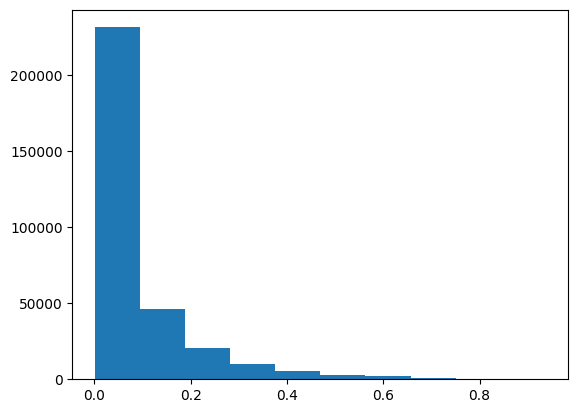

In [ ]:
plt.hist(1 / (1 + np.exp(- statsLogitModel2.fittedvalues )))

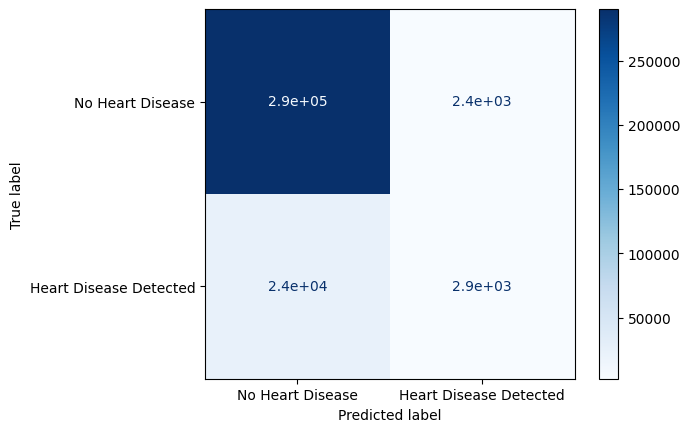

In [ ]:
cm2 = statsLogitModel2.pred_table(threshold=0.5)
confusionMatrixPlot(cm2)

### StatsModel3

**Encoded categorical variable by frequency encoding tenchqiue**

In [ ]:
frequency_encoeded_cate = frequency_encoder(categorical_data, True)

**The statsmodel3 is significant because its p-value is 0 and all predictors in the statsmodel3 are significant.**

**In the statsmodel3, the AlcoholDrinking has a positive coefficient , but a lot of coefficients become negative in this case.**

In [ ]:
statsLogitModel3 = statsLogModel(frequency_encoeded_cate, response_feature)
statsLogitModel3.summary()

Optimization terminated successfully.
         Current function value: 0.246812
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           HeartDisease   No. Observations:               319795
Model:                          Logit   Df Residuals:                   319781
Method:                           MLE   Df Model:                           13
Date:                Fri, 29 Mar 2024   Pseudo R-squ.:                  0.1554
Time:                        04:51:27   Log-Likelihood:                -78929.
converged:                       True   LL-Null:                       -93453.
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                8.2659      0.161     51.442      0.000       7.951       8.581
Smoking             -2.7198      0.080    -34.203      0.000      -2.876      -2.564
AlcoholDrinking      0.5318      0.038     14.046      0.000       0.458       0.606
Stroke              -1.4309      0.024    -58.813      0.000      -1.479      -1.383
DiffWalking         -0.9289      0.024    -38.895      0.000      -0.976      -0.882
Sex                -12.4025      0.284    -43.718      0.000     -12.958     -11.846
AgeCategory         13.8198      0.400     34.515      0.000      13.035      14.605
Race                 0.5313      0.026     20.826      0.000       0.481       0.581
Diabetic            -0.9686      0.021    -45.999      0.000      -1.010      -0.927
PhysicalActivity    -0.3379      0.028    -11.897      0.000      -0.394      -0.282
GenHealth           -2.8762      0.071    -40.526      0.000      -3.015      -2.737
Asthma              -0.2223      0.025     -8.732      0.000      -0.272      -0.172
KidneyDisease       -0.8866      0.026    -33.724      0.000      -0.938      -0.835
SkinCancer          -0.7097      0.023    -30.677      0.000      -0.755      -0.664
====================================================================================
"""

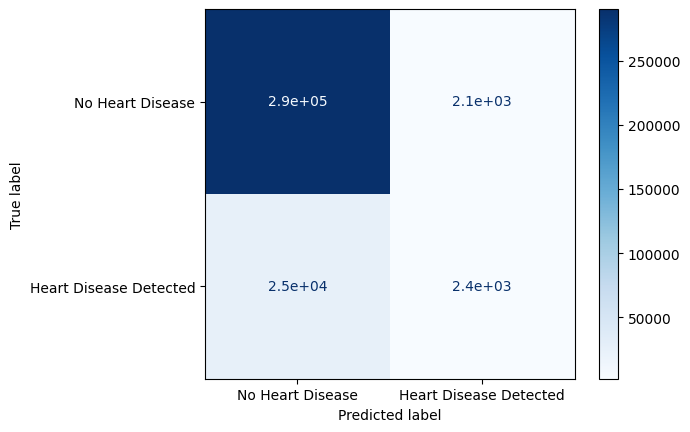

In [ ]:
cm3 = statsLogitModel3.pred_table(threshold=0.5)
confusionMatrixPlot(cm3)

**The statsmodel4 is developed by the numerical variables + the ordianl encoded categorical variables.**

**The statsmodel4 perform well becuase it is significant with all the predicted variales, but the AlcoholDrinking and SleepTime has a negative coefficient, so these are unexpected.**

In [ ]:
statsLogitModel4 = statsLogModel(pd.concat([numerical_data,
                                            ordianlEncoded_categories], axis = 1),
                                 response_feature)
statsLogitModel4.summary()

Optimization terminated successfully.
         Current function value: 0.232864
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           HeartDisease   No. Observations:               319795
Model:                          Logit   Df Residuals:                   319777
Method:                           MLE   Df Model:                           17
Date:                Fri, 29 Mar 2024   Pseudo R-squ.:                  0.2031
Time:                        04:56:34   Log-Likelihood:                -74469.
converged:                       True   LL-Null:                       -93453.
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -5.9918      0.063    -95.393      0.000      -6.115      -5.869
BMI                  0.0147      0.001     13.073      0.000       0.012       0.017
PhysicalHealth       0.0215      0.001     28.613      0.000       0.020       0.023
MentalHealth         0.0105      0.001     12.039      0.000       0.009       0.012
SleepTime           -0.0337      0.004     -7.734      0.000      -0.042      -0.025
Smoking              0.4380      0.014     31.017      0.000       0.410       0.466
AlcoholDrinking     -0.2589      0.033     -7.787      0.000      -0.324      -0.194
Stroke               1.1528      0.022     51.386      0.000       1.109       1.197
DiffWalking          0.4070      0.018     22.824      0.000       0.372       0.442
Sex                  0.7346      0.014     51.101      0.000       0.706       0.763
AgeCategory          0.2833      0.003     94.557      0.000       0.277       0.289
Race                 0.0331      0.006      5.192      0.000       0.021       0.046
Diabetic             0.2972      0.008     37.154      0.000       0.281       0.313
PhysicalActivity    -0.0905      0.016     -5.697      0.000      -0.122      -0.059
GenHealth           -0.0311      0.005     -6.103      0.000      -0.041      -0.021
Asthma               0.3503      0.019     18.358      0.000       0.313       0.388
KidneyDisease        0.6954      0.024     28.658      0.000       0.648       0.743
SkinCancer           0.1211      0.019      6.289      0.000       0.083       0.159
====================================================================================
"""

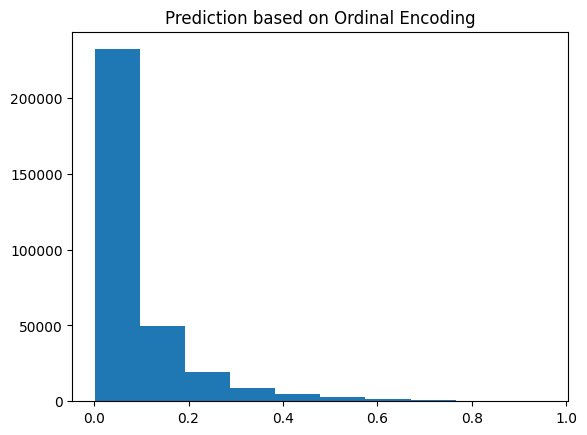

In [ ]:
proba = 1 / (1 + np.exp(- statsLogitModel4.fittedvalues))
plt.hist(proba)
plt.title("Prediction based on Ordinal Encoding")
plt.show()

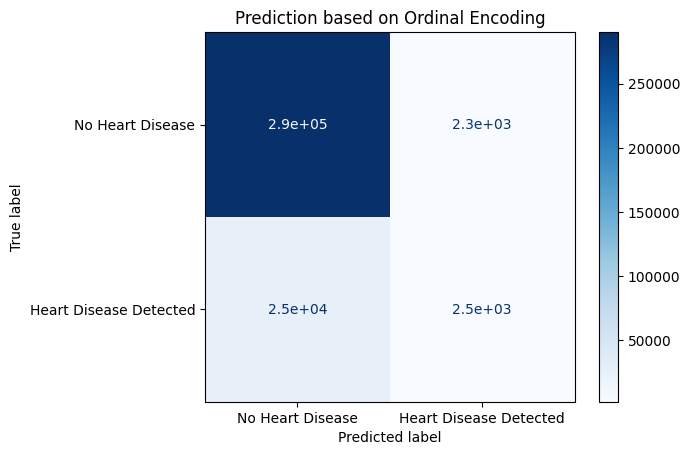

In [ ]:
cm4 = statsLogitModel4.pred_table(threshold = 0.5)
confusionMatrixPlot(cm4)
plt.title("Prediction based on Ordinal Encoding")
plt.show()

The oridnal encoding is good enough so far. We will encoded categorical variables by ordinal numbers for model.

Author: Arya Patel

# Feature Engineering


**Adding three more variables walkingSpeed, meanAge, and BMI_Distiniction to see if we can improve the model.**

## Feature Engineering Functions

**Define a general walking speed for different people from different age group.**

**For example, if she is between age 20 and 29, her general walking speed is probably 1.35 Meter/Sec according to** https://www.healthline.com/health/exercise-fitness/average-walking-speed#average-speed-by-age

In [ ]:
# Feature Engineering
# defining BMI categories option 2

def calculate_walkingspeed(age):
  if 20<=age<=29:
          return 1.35
          #featured_heartDisease.at[index, "Walking Speed"]=1.35
  elif 30<=age<=39:
          return 1.385
          # featured_heartDisease.at[index, "Walking Speed"]=1.385
  elif 40<=age<=49:
          return 1.41
           # featured_heartDisease.at[index, "Walking Speed"]=1.41
  elif 50<=age<=59:
          return 1.37
           # featured_heartDisease.at[index, "Walking Speed"]=1.37
  elif 60<=age<=69:
          return 1.29
           # featured_heartDisease.at[index, "Walking Speed"]=1.29
  elif 70<=age<=79:
          return 1.195
            #featured_heartDisease.at[index, "Walking Speed"]=1.195
  elif 80<=age<=89:
          return .955
          ## featured_heartDisease.at[index, "Walking Speed"]=.955

## BMI Distinction

**Underweight: BMI less than 18.5**

**Normal weight: BMI 18.5 to 24.9**

**Overweight: BMI 25 to 29.9**

**Obesity**:

1. Class I (Moderate): BMI 30 to 34.9
2. Class II (Severe): BMI 35 to 39.9
3. Class III (Very severe or morbid obesity): BMI 40 and above


In [ ]:
featured_heartDisease = data.copy()

featured_heartDisease['BMI_Distinction'] = pd.cut(
    featured_heartDisease['BMI'],
    bins= [0,18.5, 24.9, 29.9,34.9,39.9, float('inf')],
    labels=["Underweight", "Normal Weight", "Overweight",
            "Class I Obesity","Class II Obesity", "Class III Obesity"]
    )

## Mean Age

**The AgeCategory variable is an object type. The values are string like 20-29, so we splited the string and only convert 20 and 29 to integers then find the mean of 20 and 29 to calculate the meanAge.**

In [ ]:
temp_data = data['AgeCategory'].copy()

# featured_heartDisease.loc[featured_heartDisease['AgeCategory'] == '80 or older', 'AgeCategory'] = 80

# The value has "80 or older", so cannot split strings with "-"
  # decided to replace the value with an integer
temp_data[temp_data == '80 or older'] = 80

split_val= temp_data.astype(str).str.split('-', expand=True)

convert_ind0 = split_val[0].astype(float)
convert_ind2 = split_val[1].astype(float)
convert_ind2 = convert_ind2.fillna(80)

mean_val= (convert_ind0 + convert_ind2)/2
featured_heartDisease['MeanAge']= mean_val

In [ ]:
featured_heartDisease.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,BMI_Distinction,MeanAge
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes,Underweight,57.0
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No,Normal Weight,80.0
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No,Overweight,67.0
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes,Normal Weight,77.0
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No,Normal Weight,42.0


## Walking Speed

In [ ]:
#does same thing
#defining walking speeds
#iterate through dataFrame and set Walking Speeds based on age range
#dataset has difference in walking speed so  this is from the average walking speed by age link

featured_heartDisease['Walking_Speed'] = featured_heartDisease['MeanAge'].apply(calculate_walkingspeed)

In [ ]:
featured_heartDisease.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,...,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,BMI_Distinction,MeanAge,Walking_Speed
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,...,Yes,Yes,Very good,5.0,Yes,No,Yes,Underweight,57.0,1.370
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,...,No,Yes,Very good,7.0,No,No,No,Normal Weight,80.0,0.955
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,...,Yes,Yes,Fair,8.0,Yes,No,No,Overweight,67.0,1.290
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,...,No,No,Good,6.0,No,No,Yes,Normal Weight,77.0,1.195
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,...,No,Yes,Very good,8.0,No,No,No,Normal Weight,42.0,1.410


Author: Junze He

In [ ]:
featured_heartDisease.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   HeartDisease      319795 non-null  object  
 1   BMI               319795 non-null  float64 
 2   Smoking           319795 non-null  object  
 3   AlcoholDrinking   319795 non-null  object  
 4   Stroke            319795 non-null  object  
 5   PhysicalHealth    319795 non-null  float64 
 6   MentalHealth      319795 non-null  float64 
 7   DiffWalking       319795 non-null  object  
 8   Sex               319795 non-null  object  
 9   AgeCategory       319795 non-null  object  
 10  Race              319795 non-null  object  
 11  Diabetic          319795 non-null  object  
 12  PhysicalActivity  319795 non-null  object  
 13  GenHealth         319795 non-null  object  
 14  SleepTime         319795 non-null  float64 
 15  Asthma            319795 non-null  object  
 16  Ki

In [ ]:
# split the new dataset into numerical and categorical variables

new_numerical_features, new_categorical_fetaures = split_types(featured_heartDisease)

y = new_categorical_fetaures.HeartDisease
new_categorical_fetaures = new_categorical_fetaures.drop("HeartDisease", axis=1)

In [ ]:
# encode the new categorical variables by ordinal numbers
# then concat the new numerical and new categorical variables

new_ordianl_encoded_cateFeatures = ordinal_catfeatures_encoder(new_categorical_fetaures)
encoded_featured_heartDisease = pd.concat([new_numerical_features, new_ordianl_encoded_cateFeatures], axis=1)

**Encoded categorical variables by ordianl encoding technique and add new variables into the dataset.**

**From the heatmap, we can see there is no significant correlation in the dataset with adding three more new variables.**

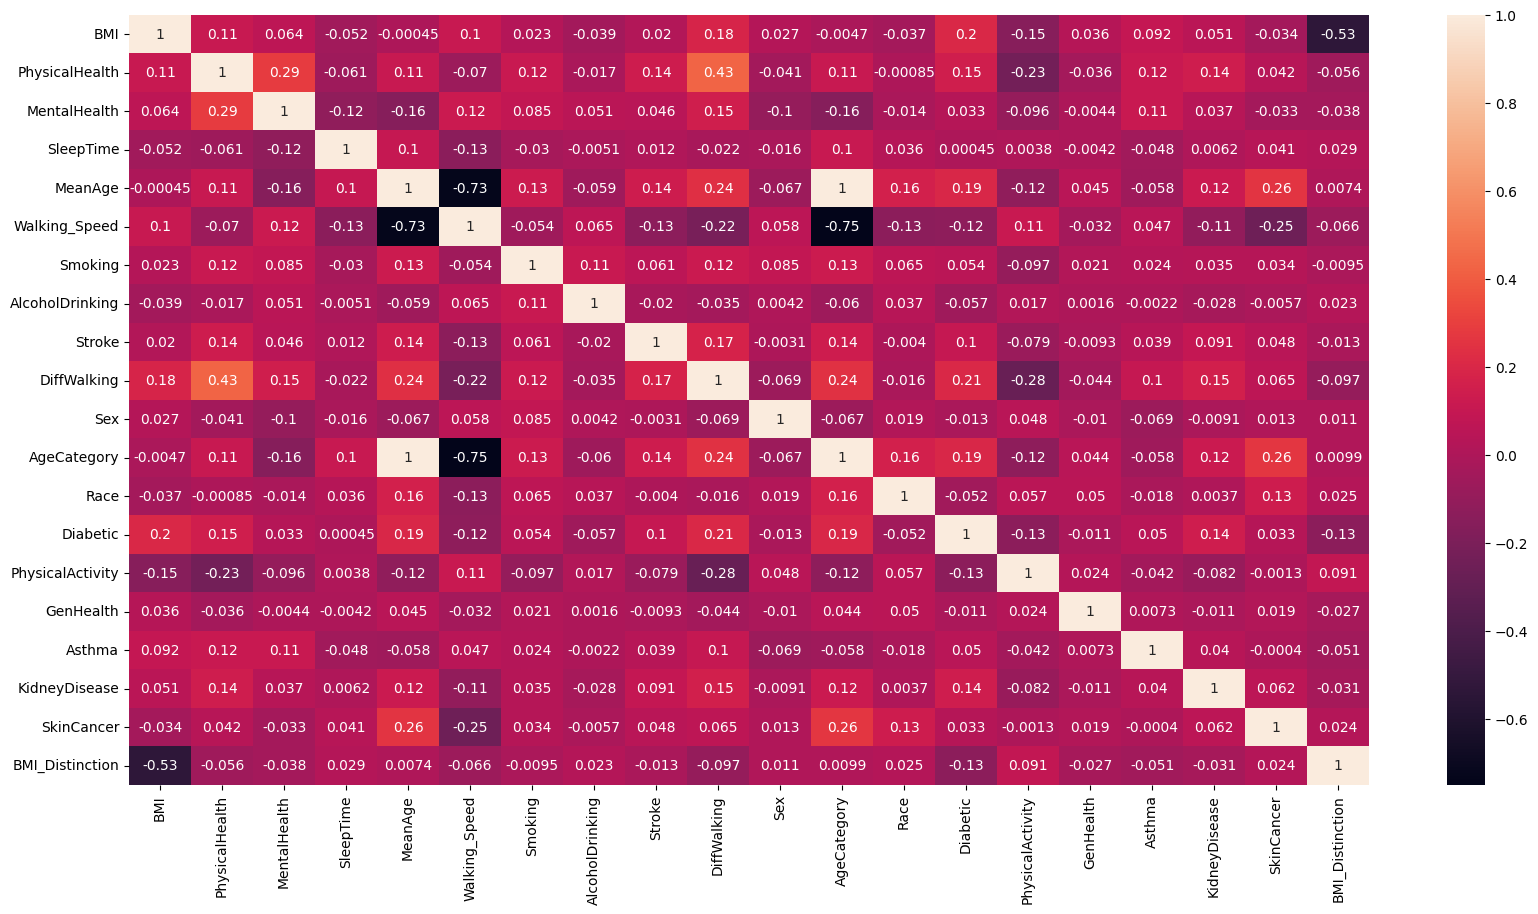

In [ ]:
correlation = encoded_featured_heartDisease.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(correlation, annot=True)
plt.show()

Author: Junze He and Giovanni Cinque

## Data Preprocessing

**Process the original dataset**

In [ ]:
# No missing values (no check)

#For checking for missing values (there are none as the non-null count is the same through all categories).
heartDisease = data.copy()
heartDisease.isna().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

In [ ]:
response_feature = heartDisease["HeartDisease"]
response_feature.value_counts()

No     292422
Yes     27373
Name: HeartDisease, dtype: int64

In [ ]:
# split categorical features and numerical features into different variables
numerical_data, categorical_data = split_types(heartDisease)
categorical_data = categorical_data.drop("HeartDisease", axis = 1)

In [ ]:
response_feature.head()

0    No
1    No
2    No
3    No
4    No
Name: HeartDisease, dtype: object

In [ ]:
# sns.heatmap(numerical_data)
numerical_data.head()

,BMI,PhysicalHealth,MentalHealth,SleepTime
0,16.60,3.0,30.0,5.0
1,20.34,0.0,0.0,7.0
2,26.58,20.0,30.0,8.0
3,24.21,0.0,0.0,6.0
4,23.71,28.0,0.0,8.0


In [ ]:
categorical_data.head()

,Smoking,AlcoholDrinking,Stroke,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,Asthma,KidneyDisease,SkinCancer
0,Yes,No,No,No,Female,55-59,White,Yes,Yes,Very good,Yes,No,Yes
1,No,No,Yes,No,Female,80 or older,White,No,Yes,Very good,No,No,No
2,Yes,No,No,No,Male,65-69,White,Yes,Yes,Fair,Yes,No,No
3,No,No,No,No,Female,75-79,White,No,No,Good,No,No,Yes
4,No,No,No,Yes,Female,40-44,White,No,Yes,Very good,No,No,No


In [ ]:
categorical_data.nunique()

Smoking              2
AlcoholDrinking      2
Stroke               2
DiffWalking          2
Sex                  2
AgeCategory         13
Race                 6
Diabetic             4
PhysicalActivity     2
GenHealth            5
Asthma               2
KidneyDisease        2
SkinCancer           2
dtype: int64

<Axes: >

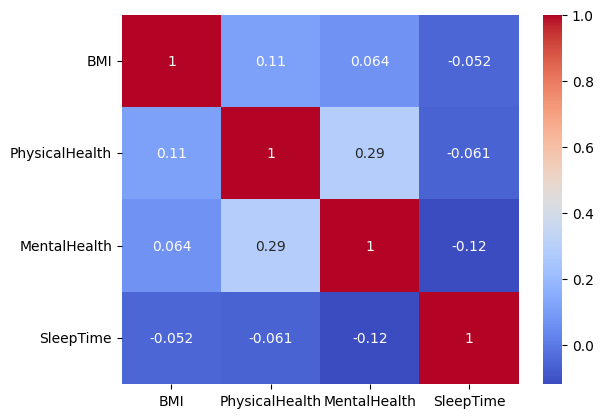

In [ ]:
#heatmap checking for collinearity of numerical dadta
sns.heatmap(numerical_data.corr(), cmap='coolwarm', annot=True)

**Different type of encoded categorical variables**

In [ ]:
# encode categorical features
# categorical_data_encoded = frequency_encoder(categorical_data)

# categorical_data_encoded = onehot_eoncoder(categorical_data)

categorical_data_encoded = ordinal_catfeatures_encoder(categorical_data)

In [ ]:
# map response feature
response_feature_encoded = response_feature.map({"Yes": 1, "No": 0})

In [ ]:
# concat numerical and categorical data
predicted_variables = pd.concat([numerical_data,
                                         categorical_data_encoded], axis=1)
predicted_variables.columns = predicted_variables.columns.astype(str)

**Oversample dataset since imbalance outcomes in response variables leading to a biased model**

In [ ]:
predicted_variables_ros, response_feature_encoded_ros = oversampling(predicted_variables, response_feature_encoded)

**Split train and test data**

**The Test size is 0.2, so the train size is 0.8.**

**Setting the shuffle to True since we want to avoid there are chuck of rows that are all Yes or No, otherwise; this also leads to a baised model.**

In [ ]:
# Split
train_x, test_x, train_y, test_y = train_test_split(predicted_variables_ros,
                                                    response_feature_encoded_ros, test_size=0.2, shuffle=True)

**Standardize variables into the same scale to avoid a big variance**

In [ ]:
# Scale
train_scaled_x = scale(train_x)
test_scaled_x = scale(test_x)

**The Yes and No in response variables have the same number of samples through oversampling technique**

In [ ]:
# Oversampling for train
# train_x_scaled_ros, train_y_ros = oversampling(train_scaled_x, train_y)
# train_y_ros.value_counts()
print(train_y.value_counts())
test_y.value_counts()

0    234043
1    233832
Name: HeartDisease, dtype: int64


1    58590
0    58379
Name: HeartDisease, dtype: int64

**There is another balancing techinique called undersampling which lower the number of majority group and make it equal to the minor group.**

In [ ]:
# random under sampling
predicted_variables_rus, response_feature_encoded_rus = undersampling(predicted_variables, response_feature_encoded)

In [ ]:
# Split
train_x_rus, test_x_rus, train_y_rus, test_y_rus = train_test_split(predicted_variables_rus,
                                                                    response_feature_encoded_rus,
                                                                    test_size=0.2, shuffle=True)

In [ ]:
# Scale
train_scaled_x_rus = scale(train_x_rus)
test_scaled_x_rus = scale(test_x_rus)

**The Tes and No in response variables the same number of samples through undersampling technique.**

In [ ]:
print(train_y_rus.value_counts())
test_y_rus.value_counts()

1    21917
0    21879
Name: HeartDisease, dtype: int64


0    5494
1    5456
Name: HeartDisease, dtype: int64

Author: Junze He

## Model

**We set the validation to be n = 5 folds which input training data into the XGBClassifier five times. Each time the training data will be divied into validation data and trainning data and test the if the model produce a consistent result.**

**During the validation process, each time we shuffle the dataset to make the results to be more reliable since we want to see how the model handle different combination of data.**

**XGBClassifier with oversampling technique**

In [ ]:
# XGBClassifier
classifier = XGBClassifier(n_estimators=20, learning_rate=0.05)
classifier.fit(
    train_scaled_x, train_y,
    verbose=False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=20, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

**The F1-Socre the of the XGBClassifier is 65% and the validation socre is 70%. The model may overfit data, but there is only 5 difference between F1-socre and validation score. Probably, the overfitting does not happen to the model**

**Setting the n_estimators to 20 and learning_rate to 0.05 gives the best performance so far.**

In [ ]:
# get predictions

predictions = classifier.predict(test_scaled_x)

In [ ]:
# test accuracy

accuracy = accuracy_score(predictions, test_y)
accuracy

0.7215330557669126

In [ ]:
# set cross validation to be n = 5 and shuffle data during each validating process

cv = ShuffleSplit(n_splits=5, test_size = 0.2, random_state=0)
validation_score = cross_val_score(classifier, train_scaled_x, train_y, cv=cv)

Shuffled Validation Mean Accuracy: 76.41%
              precision    recall  f1-score   support

           0       0.82      0.69      0.75     69621
           1       0.63      0.77      0.69     47348

    accuracy                           0.72    116969
   macro avg       0.72      0.73      0.72    116969
weighted avg       0.74      0.72      0.72    116969



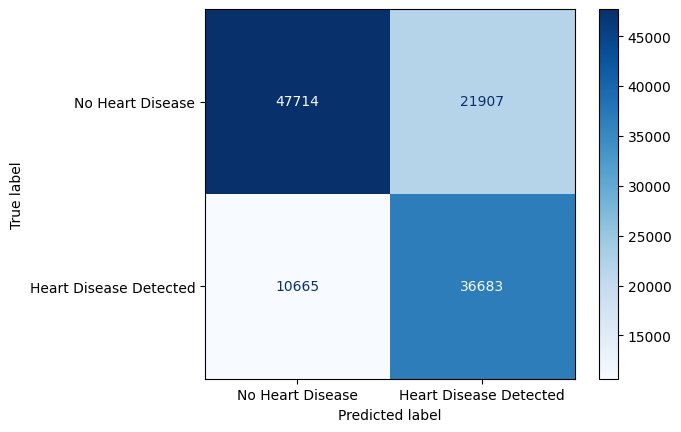

In [ ]:
# print mean validation socre , summary table, and confusion matrix

cm = confusion_matrix(predictions, test_y)
cm_dis = ConfusionMatrixDisplay(cm, display_labels=['No Heart Disease',
                                                        "Heart Disease Detected"])
print("Shuffled Validation Mean Accuracy: {:.2f}%".format(validation_score.mean()*100))
print(cm_dis.plot(cmap=plt.cm.Blues))
print(classification_report(predictions, test_y))

Author: Giovanni Cinque

**XGBClassifier with undersampling**

**The validation socre and the F1-socre have the same score, so the XGBClassifier with undersmapling did not overfit data. From the confusion matrix, we can see this XGBClassifier with undersampling outperform the XGBClassifier with oversmapling because the XGBClassifier with undersampling has less false positive and false negative.**

**Setting the n_estimators to 20 and learning_rate to 0.05 gives the best performance so far.**

In [ ]:
#XGB Classifier undersampling

classifier_rus = XGBClassifier(n_estimators=20, learning_rate=0.05)
classifier_rus.fit(
    train_scaled_x_rus, train_y_rus,
    verbose=False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=20, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

**Undersampling data**

In [ ]:
# get the prediction

predictions_rus = classifier_rus.predict(test_scaled_x_rus)

In [ ]:
# get test accuracy

accuracy_rus = accuracy_score(predictions_rus, test_y_rus)
accuracy_rus

0.7294063926940639

In [ ]:
# set cross validation to be n = 5 and shuffle data during each validating process

cv_rus = ShuffleSplit(n_splits=5, test_size = 0.2, random_state=0)
validation_score_rus = cross_val_score(classifier_rus, train_scaled_x_rus, train_y_rus, cv=cv_rus)

In [ ]:
# return confusion matrix

cm_rus = confusion_matrix(predictions_rus, test_y_rus)
cm_dis_rus = ConfusionMatrixDisplay(cm_rus, display_labels=['No Heart Disease',
                                                        "Heart Disease Detected"])

Shuffled Validation Mean Accuracy: 75.94%
              precision    recall  f1-score   support

           0       0.82      0.70      0.75      6437
           1       0.64      0.78      0.70      4513

    accuracy                           0.73     10950
   macro avg       0.73      0.74      0.73     10950
weighted avg       0.74      0.73      0.73     10950



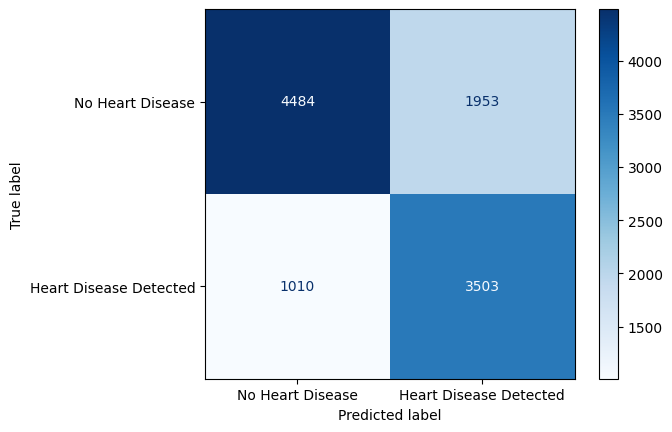

In [ ]:
# print mean validation socre , summary table, and confusion matrix

print("Shuffled Validation Mean Accuracy: {:.2f}%".format(validation_score_rus.mean()*100))
print(cm_dis_rus.plot(cmap=plt.cm.Blues))
print(classification_report(predictions_rus, test_y_rus))

Author: Junze He

### Pipeline

**Implement RandomForestClassifier, DecisionTreeClassifier, and LogisticClassifier with pipeline. We don't implement XGBClassifier with pipeline because if we decide to pass validation and validation test data to the XGBClassifier, the pipeline won't be able to impute and process validation data as well.**

**The piepline structure makes us easier to create a model. The following  pipelineModel function requires four arguments to create a model.**

1. model: which type of model

2. x_ros: predicted variables

3. y_ros: response variables

4. ordinalEncoder: is a boolean argument and default value is True. If set ordianlEncoder to True, encode categorical variable by ordinal numbers, otherwise; encode categorical variable by dummy variables.

In [ ]:
# The pipelineModel function returns a model, confusion matrix, summary table, and validation score.

def pipelineModel(model, x_ros, y_ros, ordinalEncoder=True):
  # shuffle and set corss validation to n = 5 folds
  cv = ShuffleSplit(n_splits=5, test_size = 0.2, random_state=0)

  # divide data into train and test
  train_x, test_x, train_y, test_y = train_test_split(
      x_ros,
      y_ros,
      test_size=0.2,
      shuffle=True
      )

  # impute missing values with median in numerical variables
  numerical_transformer = SimpleImputer(strategy="median")

  # impute missing values with most frequent value in categorical variables
  # encode categorical variable by ordinal numbers
  categorical_transformer = Pipeline(
      steps=[
      ("Imputer", SimpleImputer(strategy="most_frequent")),
      ("ordinal", OrdinalEncoder())
      ]
  )

  # use columnTransformer to combine preprocessing steps in both numerical and categorical variables
  preprocessor = ColumnTransformer(
      transformers=[
          ("num", numerical_transformer, numerical_cols),
          ("cat", categorical_transformer, categorical_cols),
      ]
  )

  # after preprocess data, we scale variables into the same unit, then create a model
  my_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
         ('scaler', StandardScaler()),
        ("model", model)
    ]
  )

  my_pipeline.fit(train_x, train_y)

  # get predictions
  predictions = my_pipeline.predict(test_x)
  # get confusion matrix
  cm = confusion_matrix(predictions, test_y)
  # produce a summary of the model
  report = classification_report(predictions, test_y)
  # test the model by corss validation
  validation_score = cross_val_score(my_pipeline, train_x, train_y, cv=cv)

  return my_pipeline, cm, report, validation_score



**Splits columns into numerical and categorical type because piepline needs to impute values based on column names**

In [ ]:
def splitCols(data):
  numerical_cols = [i for i in x.columns if x[i].dtype in ["int64", "float64"]]
  categorical_cols = [i for i in x.columns if x[i].dtype == "object"]
  return numerical_cols, categorical_cols

In [ ]:
# def cross_validation(model, x, y):
#   cv = ShuffleSplit(n_splits=5, test_size = 0.2, random_state=0)
#   validation= cross_val_score(model, x, y, cv = cv)
#   return validation

In [ ]:
y = heartDisease.copy().HeartDisease
x = heartDisease.copy().drop("HeartDisease", axis=1)

In [ ]:
numerical_cols, categorical_cols = splitCols(x)
y = y.map({"No": 0, "Yes":1})
x_ros, y_ros = oversampling(x, y)

**RandomForestClassifier with oversampling**

**The randomForestClassifier achives a decent result in both validation and F1-socre. From the confusion matrix, we can see the model performs really well. It has a lower false positive and false negative than XGBClassifier.**

In [ ]:
# RandomForestClassifier
# n_estimator: how many trees in the model which has a series of decision trees
rfc_model = RandomForestClassifier(n_estimators=35)
rfc_pipeline, rfc_cm, rfc_report, rfc_validation_score = pipelineModel(rfc_model, x_ros, y_ros)

Shuffled Validation Mean Accuracy: 95.93%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     54821
           1       1.00      0.94      0.97     62148

    accuracy                           0.97    116969
   macro avg       0.97      0.97      0.97    116969
weighted avg       0.97      0.97      0.97    116969



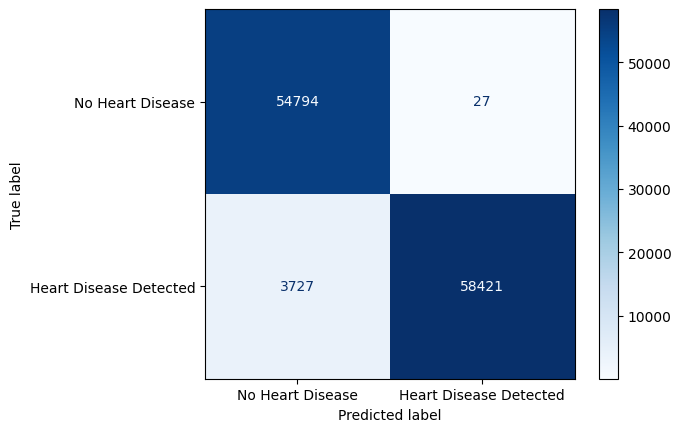

In [ ]:
confusionMatrixPlot(rfc_cm)
print("Shuffled Validation Mean Accuracy: {:.2f}%".format(rfc_validation_score.mean()*100))
print(rfc_report)

Author: Jun Ryu

**DecisionTreeClassifier**

**The DecisionTreeClassifier also achieve a decent result in both validation and F1-socre. From the confsuion matrix, we can see the results are similar to the RandomForestClassifier.**

In [ ]:
# DecisionTrees with a tree
# max_depth: the depth of a tree
model_dt = DecisionTreeClassifier(max_depth=35, random_state=1234)
dt_pipeline, dt_cm, dt_report, dt_validation_score = pipelineModel(model_dt, x_ros, y_ros)

Shuffled Validation Mean Accuracy: 94.03%
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     52900
           1       1.00      0.91      0.95     64069

    accuracy                           0.95    116969
   macro avg       0.95      0.95      0.95    116969
weighted avg       0.95      0.95      0.95    116969



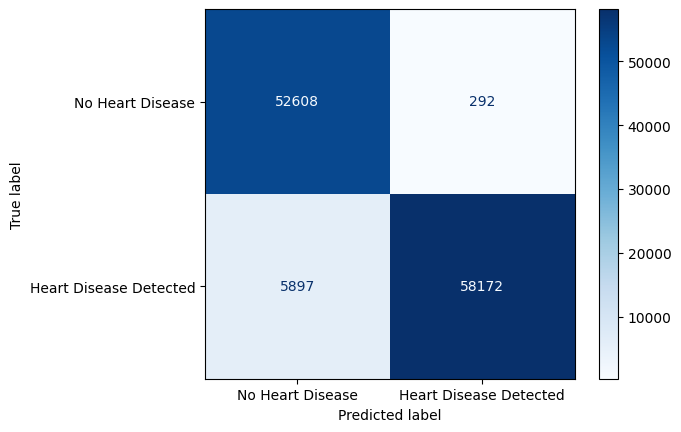

In [ ]:
confusionMatrixPlot(dt_cm)
print("Shuffled Validation Mean Accuracy: {:.2f}%".format(dt_validation_score.mean()*100))
print(dt_report)

**Logistic Regression with oversampling and ordinal Encoding**

**The logistic regression does not perform well same as the RandomForestClassifier and the DecisionTreeClassifier since it has a high false positive and false negative, but the model does not overfit data.**

**The parameter C in the logistic regression is the strength of regularization which is used to improve the model and avoid overfitting. We set the strength of regularization to 0.5 because this gives the best performance of the model.**


In [ ]:
# Logistic Regression
model_lr = LogisticRegression(C=0.5, random_state=1234)
lr_pipeline, lr_cm, lr_report, lr_validation_score = pipelineModel(model_lr, x_ros, y_ros)

Shuffled Validation Mean Accuracy: 75.05%
              precision    recall  f1-score   support

           0       0.74      0.76      0.75     57044
           1       0.76      0.75      0.76     59925

    accuracy                           0.75    116969
   macro avg       0.75      0.75      0.75    116969
weighted avg       0.75      0.75      0.75    116969



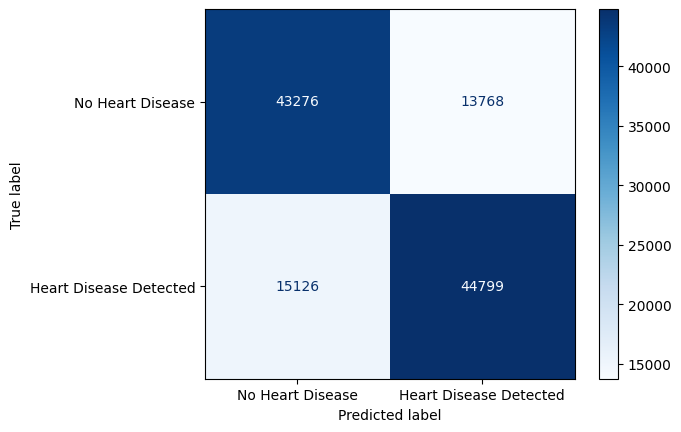

In [ ]:
confusionMatrixPlot(lr_cm)
print("Shuffled Validation Mean Accuracy: {:.2f}%".format(lr_validation_score.mean()*100))
print(lr_report)

**The oversampling and undersampling techniques are good methods to deal with imbalance outcomes in a response variable, but it does not work for all models. We developed four models above, and we can see random forest classifier and decision tree classifier outperform logistic regression and XGBClassifier.**

**The more data we have, the better the model we can develop. This is true when it applies to the random forest classifier because the random forest classifier can handle the large dataset, minimize variance, and reduce overfitting. More importantly, the random forest and decision tree classifier can handle imbalanced data and the effect of oversampling and undersampling can be applied to these two models.**

**However, XGBClassifier cannot handle imbalanced data well because gradient descent cannot boost imbalanced data. The effect of oversampling and undersampling does not work for the XGBClassifier, and this is demonstrated in the world, but we found XGBClassifier with undersampling produces slightly better results than the oversampling one because it does not seem that it overfits data**

**Moreover, the logistic regression maximizes the log-likelihood function to predict events. Even though it cannot handle imbalanced data, in this case, after the oversampling, its performance is not bad compared to XGBClassifier with oversampling.**

Author: Junze He

### RandomForestClassifier with adding three more featuresn and ordinal encoding

The results does not change or the model is not improved. The model produces almost the same F1 and validation score compared to the RandomForestClassifier wit the original dataset.

In [ ]:
x_added_features = featured_heartDisease.drop('HeartDisease', axis=1).copy()
x_added_features_ros, y_added_features_ros = oversampling(x_added_features, y)
y_added_features_ros.value_counts()

0    292422
1    292422
Name: HeartDisease, dtype: int64

In [ ]:
x_added_features_ros.head()

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,BMI_Distinction,MeanAge,Walking_Speed
0,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes,Underweight,57.0,1.370
1,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No,Normal Weight,80.0,0.955
2,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No,Overweight,67.0,1.290
3,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes,Normal Weight,77.0,1.195
4,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No,Normal Weight,42.0,1.410


In [ ]:
added_features_rfc_pipeline, added_features_rfc_cm, added_features_rfc_report, added_features_rfc_validation_score = pipelineModel(
    RandomForestClassifier(n_estimators=30),
    x_added_features_ros,
    y_added_features_ros
)

Shuffled Validation Mean Accuracy: 96.10%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     54746
           1       1.00      0.94      0.97     62223

    accuracy                           0.97    116969
   macro avg       0.97      0.97      0.97    116969
weighted avg       0.97      0.97      0.97    116969



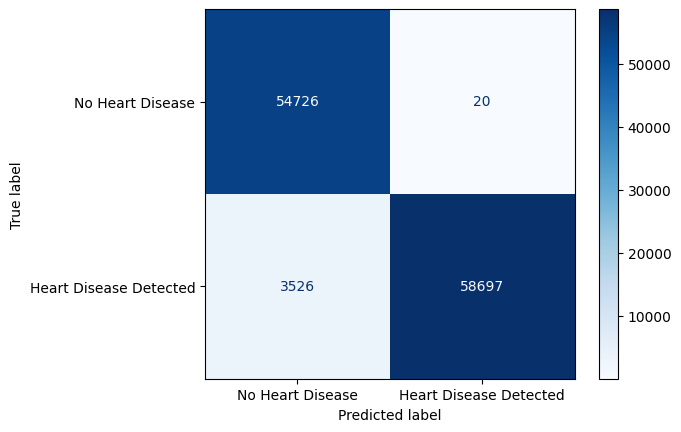

In [ ]:
confusionMatrixPlot(added_features_rfc_cm)
print("Shuffled Validation Mean Accuracy: {:.2f}%".format(added_features_rfc_validation_score.mean()*100))
print(added_features_rfc_report)

**The added variables BMI_Distinction, MeanAge, and Walking_Speed does not provide any extra improvement to the RandForestClassifier, so these added variables are not significant to the model.**

**Next, I will update the probability of predicting event Yes and No, so users can input data according to their information to get probbaility of getting heart disease. Updating....**